# GROUP MEMBER NAMES AND UID


**Member 1**
*   **Name**: Jim Solomon
*   **UID**: 005371849

**Member 2**
*   **Name**: Yujie Wang
*   **UID**: 406077623

**Member 3**
*   **Name**: Zihan Wang
*   **UID**: 306077614

**Member 4**
*   **Name**: Zilin Zeng
*   **UID**: 006073844




In [4]:
!pip install torchinfo

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter   # print to tensorboard
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy
from sklearn import metrics
from torchinfo import summary
from tqdm import tqdm
from scipy import signal
import librosa
import random
import time
from google.colab import drive
drive.mount('/content/drive')
# change to your folder directory
# %cd "/content/drive/MyDrive/Colab Notebooks/Classes/ECE C247/Project/project"
%cd "/content/drive/MyDrive/EE247_FinalProject/project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EE247_FinalProject/project


In [6]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

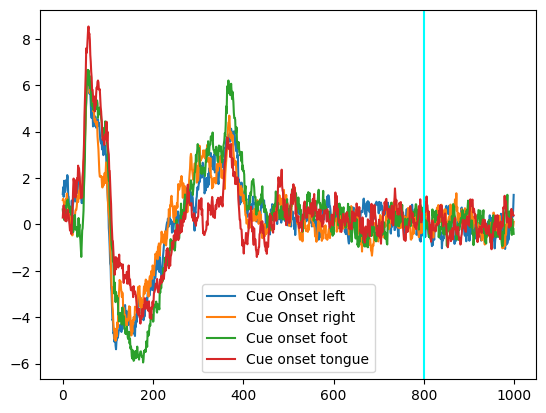

In [7]:
## Visualizing the data


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=800, label='line at t=800',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])



In [8]:
def train_data_prep(X,y,sub_sample,average,noise,time_sel):
    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))


    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                      (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    return total_X,total_y



def data_prep_stft(data_x):
    fs = 250
    nperseg = 100
    _, _, X_stft = signal.stft(data_x, fs=fs, nperseg=nperseg, nfft=nperseg)  # keep the same frequency bins, pad on time
    return np.abs(X_stft)


def data_lpc(data_x):
    X_lpc = librosa.lpc(data_x, order=15)
    return X_lpc


def data_cep(data_x):
    X_mfcc = librosa.feature.mfcc(y=data_x, sr=250, n_fft=50, n_mfcc=39)
    X_cep = np.max(X_mfcc, axis=-1)
    return X_cep


def val_test_data_prep(X,time_sel):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_sel]

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_aug = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_aug

    return total_X


In [9]:
def data_loader(X_train_valid, y_train_valid, model_choice="EEG", time_sel=800, z_norm=False):
    num_data = X_train_valid.shape[0]
    data_ls = np.arange(num_data)
    np.random.shuffle(data_ls)

    train_ls = data_ls[num_data//5::]
    train_label = y_train_valid[train_ls]
    train_data = X_train_valid[train_ls]
    train_data_aug, train_label_aug = train_data_prep(train_data, train_label,2,2,True,time_sel)

    if model_choice == "CNN":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], train_data_aug.shape[1], train_data_aug.shape[2], 1)

    if model_choice == "EEG":
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])

    if model_choice == "STFT":
        train_data_stft_raw = data_prep_stft(train_data)    # STFT on untruncated data
        train_data_stft_aug = data_prep_stft(train_data_aug)    # STFT on filtered data
        train_data_stft_aug_zp = np.zeros([train_data_stft_aug.shape[0], train_data_stft_aug.shape[1], train_data_stft_aug.shape[2], train_data_stft_raw.shape[-1]])
        train_data_stft_aug_zp[:,:,:,0:train_data_stft_aug.shape[-1]] = train_data_stft_aug
        train_data_aug = np.concatenate((train_data_stft_raw, train_data_stft_aug_zp), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)

    if model_choice == "Speech":
        train_data_lpc= data_lpc(train_data)
        train_data_cep = data_cep(train_data)
        train_data_aug_lpc = data_lpc(train_data_aug)
        train_data_aug_cep = data_cep(train_data_aug)
        train_data_speech = np.concatenate((train_data_lpc,train_data_cep), axis=-1)
        train_data_aug_speech= np.concatenate((train_data_aug_lpc,train_data_aug_cep), axis=-1)
        train_data_aug = np.concatenate((train_data_speech, train_data_aug_speech), axis=0)
        train_label_aug = np.concatenate((train_label, train_label_aug), axis=0)
        train_data_aug = train_data_aug.reshape(train_data_aug.shape[0], 1, train_data_aug.shape[1], train_data_aug.shape[2])


    val_ls = data_ls[0:num_data//5]
    val_label = y_train_valid[val_ls]
    val_data = X_train_valid[val_ls]
    val_data_aug = val_test_data_prep(val_data, time_sel)

    if model_choice == "CNN":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], 1)

    if model_choice == "EEG":
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])

    if model_choice == "STFT":
        val_data_aug = data_prep_stft(val_data_aug)
        val_stft_aug_zp = np.zeros([val_data_aug.shape[0], val_data_aug.shape[1], val_data_aug.shape[2], train_data_stft_raw.shape[-1]])
        val_stft_aug_zp[:,:,:,0:val_data_aug.shape[-1]] = val_data_aug
        val_data_aug = val_stft_aug_zp

    if model_choice == "Speech":
        val_data_aug_lpc = data_lpc(val_data_aug)
        val_data_aug_cep = data_cep(val_data_aug)
        val_data_aug = np.concatenate((val_data_aug_lpc,val_data_aug_cep), axis=-1)
        val_data_aug = val_data_aug.reshape(val_data_aug.shape[0], 1, val_data_aug.shape[1], val_data_aug.shape[2])


    print("My training data: ", train_data_aug.shape)
    print("My training label: ", train_label_aug.shape)
    print()
    print("My val data: ", val_data_aug.shape)
    print("My val label: ", val_label.shape)
    print()

    return torch.from_numpy(train_data_aug), torch.from_numpy(train_label_aug), torch.from_numpy(val_data_aug), torch.from_numpy(val_label)


def batch_data(train_num, batch_size):
    data_ls = np.arange(train_num)
    np.random.shuffle(data_ls)  # shuffle augmented training data
    split_ls = np.repeat(batch_size, train_num//batch_size)

    if train_num%batch_size != 0:
        split_ls = np.hstack([split_ls, train_num%batch_size])

    split_ls = np.cumsum(split_ls)
    mini_batch_ls = np.split(data_ls, split_ls)
    del mini_batch_ls[-1]

    return mini_batch_ls

In [10]:
np.random.seed(247)
x_train_CNN, y_train_CNN, x_valid_CNN, y_valid_CNN= data_loader(X_train_valid, y_train_valid, model_choice="CNN")
x_train_EEG, y_train_EEG, x_valid_EEG, y_valid_EEG = data_loader(X_train_valid, y_train_valid, model_choice="EEG")

My training data:  (6768, 22, 400, 1)
My training label:  (6768,)

My val data:  (423, 22, 400, 1)
My val label:  (423,)

My training data:  (6768, 1, 22, 400)
My training label:  (6768,)

My val data:  (423, 1, 22, 400)
My val label:  (423,)



In [11]:
###################################################################################
## Plotting Figures ###############################################################
###################################################################################
def make_figure(training_acc, validation_acc, name="fig"):
    x_axis = np.arange(0, len(training_acc))
    plt.plot(x_axis, training_acc, color='r', label='training')
    plt.plot(x_axis, validation_acc, color='g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name + '.png')
    plt.show()

In [12]:
###################################################################################
## Training Function ##############################################################
###################################################################################
def train_model(data, optimizer, criterion, model, batch_size = 64, epochs = 30, anneal_=False, scheduler_coeff = 10, T_mult=1):
    # Getting the appropriate cuda device
    # Initialize for each model setup
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # Getting our data for training and validation
    x_train = data['x_train'].to(device, dtype = torch.float)
    y_train = data['y_train'].to(device, dtype = torch.long)
    x_valid = data['x_valid'].to(device, dtype=torch.float)
    y_valid = data['y_valid'].to(device, dtype=torch.long)
    num_training_data = x_train.shape[0]
    num_val_data = x_valid.shape[0]
    num_iterations = len(batch_data(num_training_data, batch_size))

    if anneal_ == True:
        print("Annealing")
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations*scheduler_coeff)

    # Placing our model parameters in the GPU
    print("Current Model: ", model)

    # Initializing variables for tracking our loss and accuracies
    running_loss = 0
    training_acc = []
    validation_acc = []

    np.random.seed(247)
    torch.manual_seed(147)
    # Training loop
    for epoch in tqdm(range(epochs)):
        batch_list = batch_data(num_training_data, batch_size)
        # Preparing the model for training
        model.train()

        print("Epoch: ", epoch + 1)
        running_loss = 0.0

        for iter_ in range(num_iterations):
            train_batch = x_train[batch_list[iter_]].to(device, dtype=torch.float)
            label_batch = y_train[batch_list[iter_]].to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(train_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            if anneal_ == True:
                scheduler.step()
                # print(scheduler.get_last_lr())

            running_loss += loss.item()

            if (iter_+1) % (num_iterations//4) == 0:
                print('[{}, {}] loss: {:.3f}'.format(epoch + 1, iter_ + 1, running_loss / (num_iterations//4)))
                running_loss = 0.0

        # Validation


        with torch.no_grad():
            model.eval()      # set to testing mode for BN and Dropout
            print("Check: ", x_valid.shape)
            val_out = model(x_valid)     # no Batch in testing mode

            train_predict = torch.argmax(outputs, dim = 1)
            train_acc = torch.mean(torch.eq(label_batch, train_predict).float(), dtype = torch.float)
            training_acc.append(train_acc.cpu().numpy())

            val_predict = torch.argmax(val_out, dim=1)
            val_acc  = torch.mean(torch.eq(y_valid, val_predict).float(), dtype = torch.float)
            validation_acc.append(val_acc.cpu().numpy())
            print('Validation Accuracy: {}'.format(val_acc, dtype = torch.float))


        if (anneal_ == True) and ((epoch+1) % scheduler_coeff == 0):
            print('Reset scheduler after finishing epoch: ', epoch+1)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_mult=T_mult, T_0=num_iterations*scheduler_coeff)

    print("Finish Training")
    return np.array(training_acc), np.array(validation_acc)


In [13]:
###################################################################################
## Testing Function ##############################################################
###################################################################################
def test_model(model, model_choice="CNN", X_test=X_test, y_test=y_test,time_sel=800):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # Assuming that we are on a CUDA machine, this should print a CUDA device:

    # check test acc
    x_test = val_test_data_prep(X_test,time_sel)

    if model_choice == "STFT":
        x_test = data_prep_stft(x_test)
        x_test_zp = np.zeros([x_test.shape[0], x_test.shape[1], x_test.shape[2], x_train_STFT.shape[-1]])
        x_test_zp[:,:,:,0:x_test.shape[-1]] = x_test
        x_test = x_test_zp

    if model_choice == "Speech":
        x_test_lpc = data_lpc(x_test)
        x_test_cep = data_cep(x_test)
        x_test = np.concatenate((x_test_lpc,x_test_cep), axis=-1)


    if type(x_test)!=torch.Tensor:
        x_test = torch.from_numpy(x_test).to(device, dtype=torch.float)

        if model_choice == "CNN":
            x_test = x_test.unsqueeze(-1)

        if model_choice == "EEG" or model_choice == "Speech":
            x_test = x_test.unsqueeze(1)


    if type(y_test)!=torch.Tensor:
        y_test = torch.from_numpy(y_test).to(device, dtype=torch.long)


    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()     # set to testing mod for BN and Dropout
        test_out = model(x_test)
        test_predict = torch.argmax(test_out, dim=1)

    num_test = x_test.shape[0]
    test_acc  = torch.sum((test_predict == y_test)).item()/num_test
    print("Test accuracy for ", "RESNET", "is: ", test_acc)


# **MODEL DEFINITION**





> Here, we define the model used in this experiment. Our model is:
1.  EEG Net + Cosine Annealing

In [14]:
###################################################################################
## Classification with a ResNet ###################################################
###################################################################################

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ELU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.elu = nn.ELU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.elu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 4):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(22, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ELU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet = ResNet(ResidualBlock, [2, 4, 4, 2], num_classes = 4).to(device)
summary(resnet, input_size=x_train_CNN[0:64].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 4]                   --
├─Sequential: 1-1                        [64, 64, 200, 1]          --
│    └─Conv2d: 2-1                       [64, 64, 200, 1]          69,056
│    └─BatchNorm2d: 2-2                  [64, 64, 200, 1]          128
│    └─ELU: 2-3                          [64, 64, 200, 1]          --
├─MaxPool2d: 1-2                         [64, 64, 100, 1]          --
├─Sequential: 1-3                        [64, 64, 100, 1]          --
│    └─ResidualBlock: 2-4                [64, 64, 100, 1]          --
│    │    └─Sequential: 3-1              [64, 64, 100, 1]          37,056
│    │    └─Sequential: 3-2              [64, 64, 100, 1]          37,056
│    │    └─ELU: 3-3                     [64, 64, 100, 1]          --
│    └─ResidualBlock: 2-5                [64, 64, 100, 1]          --
│    │    └─Sequential: 3-4              [64, 64, 100, 1]          37,05

# **Training Our Models**

In [16]:
###################################################################################
## Training and Test The EEGNet with Annealing ####################################
###################################################################################

resnet = ResNet(ResidualBlock, [2, 4, 4, 2], num_classes = 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=5e-4, eps=1e-07, weight_decay=0.001)
num_epoch, batch_size = 50, 64
data_cnn = {
    "x_train": x_train_CNN,
    "y_train": y_train_CNN,
    "x_valid": x_valid_CNN,
    "y_valid": y_valid_CNN
}
training_acc_CNN, validation_acc_CNN = train_model(data_cnn, optimizer, criterion, resnet, batch_size, num_epoch, anneal_=True,  T_mult=1)
start_time = time.time()
test_model(resnet, model_choice="CNN", X_test=X_test, y_test=y_test)
print("Time To Run: ", time.time() - start_time, "seconds")

Annealing
Current Model:  ResNet(
  (conv1): Sequential(
    (0): Conv2d(22, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (elu): ELU(alpha=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1
[1, 26] loss: 1.581
[1, 52] loss: 1.335
[1, 78] loss: 1.245
[1, 104] loss: 1.193
Check:  torch.Size([423, 22, 400, 1])


  2%|▏         | 1/50 [00:07<06:04,  7.43s/it]

Validation Accuracy: 0.38297873735427856
Epoch:  2
[2, 26] loss: 0.982
[2, 52] loss: 0.984
[2, 78] loss: 0.933
[2, 104] loss: 0.819
Check:  torch.Size([423, 22, 400, 1])


  4%|▍         | 2/50 [00:13<05:31,  6.90s/it]

Validation Accuracy: 0.48463356494903564
Epoch:  3
[3, 26] loss: 0.663
[3, 52] loss: 0.572
[3, 78] loss: 0.565
[3, 104] loss: 0.595
Check:  torch.Size([423, 22, 400, 1])


  6%|▌         | 3/50 [00:20<05:19,  6.79s/it]

Validation Accuracy: 0.49408984184265137
Epoch:  4
[4, 26] loss: 0.347
[4, 52] loss: 0.391
[4, 78] loss: 0.365
[4, 104] loss: 0.249
Check:  torch.Size([423, 22, 400, 1])


  8%|▊         | 4/50 [00:27<05:10,  6.76s/it]

Validation Accuracy: 0.5035461187362671
Epoch:  5
[5, 26] loss: 0.196
[5, 52] loss: 0.171
[5, 78] loss: 0.121
[5, 104] loss: 0.098
Check:  torch.Size([423, 22, 400, 1])


 10%|█         | 5/50 [00:34<05:05,  6.78s/it]

Validation Accuracy: 0.5035461187362671
Epoch:  6
[6, 26] loss: 0.071
[6, 52] loss: 0.045
[6, 78] loss: 0.049
[6, 104] loss: 0.032
Check:  torch.Size([423, 22, 400, 1])


 12%|█▏        | 6/50 [00:41<04:59,  6.81s/it]

Validation Accuracy: 0.5295508503913879
Epoch:  7
[7, 26] loss: 0.017
[7, 52] loss: 0.010
[7, 78] loss: 0.013
[7, 104] loss: 0.006
Check:  torch.Size([423, 22, 400, 1])


 14%|█▍        | 7/50 [00:47<04:54,  6.85s/it]

Validation Accuracy: 0.5271867513656616
Epoch:  8
[8, 26] loss: 0.003
[8, 52] loss: 0.003
[8, 78] loss: 0.003
[8, 104] loss: 0.003
Check:  torch.Size([423, 22, 400, 1])


 16%|█▌        | 8/50 [00:55<04:50,  6.92s/it]

Validation Accuracy: 0.5437352061271667
Epoch:  9
[9, 26] loss: 0.002
[9, 52] loss: 0.002
[9, 78] loss: 0.003
[9, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 18%|█▊        | 9/50 [01:02<04:46,  6.98s/it]

Validation Accuracy: 0.5508274435997009
Epoch:  10
[10, 26] loss: 0.002
[10, 52] loss: 0.002
[10, 78] loss: 0.002
[10, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 20%|██        | 10/50 [01:09<04:41,  7.05s/it]

Validation Accuracy: 0.5484633445739746
Reset scheduler after finishing epoch:  10
Epoch:  11
[11, 26] loss: 0.003
[11, 52] loss: 0.190
[11, 78] loss: 0.891
[11, 104] loss: 0.577
Check:  torch.Size([423, 22, 400, 1])


 22%|██▏       | 11/50 [01:16<04:37,  7.11s/it]

Validation Accuracy: 0.4586288332939148
Epoch:  12
[12, 26] loss: 0.391
[12, 52] loss: 0.339
[12, 78] loss: 0.384
[12, 104] loss: 0.258
Check:  torch.Size([423, 22, 400, 1])


 24%|██▍       | 12/50 [01:23<04:32,  7.18s/it]

Validation Accuracy: 0.5768321752548218
Epoch:  13
[13, 26] loss: 0.219
[13, 52] loss: 0.220
[13, 78] loss: 0.195
[13, 104] loss: 0.167
Check:  torch.Size([423, 22, 400, 1])


 26%|██▌       | 13/50 [01:31<04:27,  7.23s/it]

Validation Accuracy: 0.5366430282592773
Epoch:  14
[14, 26] loss: 0.102
[14, 52] loss: 0.070
[14, 78] loss: 0.083
[14, 104] loss: 0.053
Check:  torch.Size([423, 22, 400, 1])


 28%|██▊       | 14/50 [01:38<04:21,  7.26s/it]

Validation Accuracy: 0.5721040368080139
Epoch:  15
[15, 26] loss: 0.033
[15, 52] loss: 0.029
[15, 78] loss: 0.027
[15, 104] loss: 0.022
Check:  torch.Size([423, 22, 400, 1])


 30%|███       | 15/50 [01:45<04:13,  7.25s/it]

Validation Accuracy: 0.5531914830207825
Epoch:  16
[16, 26] loss: 0.012
[16, 52] loss: 0.009
[16, 78] loss: 0.008
[16, 104] loss: 0.006
Check:  torch.Size([423, 22, 400, 1])


 32%|███▏      | 16/50 [01:53<04:05,  7.23s/it]

Validation Accuracy: 0.5744680762290955
Epoch:  17
[17, 26] loss: 0.005
[17, 52] loss: 0.002
[17, 78] loss: 0.003
[17, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 34%|███▍      | 17/50 [02:00<03:57,  7.20s/it]

Validation Accuracy: 0.5697399377822876
Epoch:  18
[18, 26] loss: 0.002
[18, 52] loss: 0.002
[18, 78] loss: 0.001
[18, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 36%|███▌      | 18/50 [02:07<03:49,  7.17s/it]

Validation Accuracy: 0.5626477599143982
Epoch:  19
[19, 26] loss: 0.001
[19, 52] loss: 0.001
[19, 78] loss: 0.002
[19, 104] loss: 0.001
Check:  torch.Size([423, 22, 400, 1])


 38%|███▊      | 19/50 [02:14<03:41,  7.14s/it]

Validation Accuracy: 0.5697399377822876
Epoch:  20
[20, 26] loss: 0.001
[20, 52] loss: 0.001
[20, 78] loss: 0.001
[20, 104] loss: 0.001
Check:  torch.Size([423, 22, 400, 1])


 40%|████      | 20/50 [02:21<03:33,  7.12s/it]

Validation Accuracy: 0.5744680762290955
Reset scheduler after finishing epoch:  20
Epoch:  21
[21, 26] loss: 0.001
[21, 52] loss: 0.002
[21, 78] loss: 0.001
[21, 104] loss: 0.004
Check:  torch.Size([423, 22, 400, 1])


 42%|████▏     | 21/50 [02:28<03:26,  7.11s/it]

Validation Accuracy: 0.5295508503913879
Epoch:  22
[22, 26] loss: 0.263
[22, 52] loss: 0.835
[22, 78] loss: 0.427
[22, 104] loss: 0.301
Check:  torch.Size([423, 22, 400, 1])


 44%|████▍     | 22/50 [02:35<03:19,  7.12s/it]

Validation Accuracy: 0.4822694957256317
Epoch:  23
[23, 26] loss: 0.210
[23, 52] loss: 0.174
[23, 78] loss: 0.146
[23, 104] loss: 0.139
Check:  torch.Size([423, 22, 400, 1])


 46%|████▌     | 23/50 [02:42<03:12,  7.13s/it]

Validation Accuracy: 0.5271867513656616
Epoch:  24
[24, 26] loss: 0.081
[24, 52] loss: 0.059
[24, 78] loss: 0.063
[24, 104] loss: 0.055
Check:  torch.Size([423, 22, 400, 1])


 48%|████▊     | 24/50 [02:49<03:05,  7.13s/it]

Validation Accuracy: 0.5413711667060852
Epoch:  25
[25, 26] loss: 0.026
[25, 52] loss: 0.017
[25, 78] loss: 0.009
[25, 104] loss: 0.010
Check:  torch.Size([423, 22, 400, 1])


 50%|█████     | 25/50 [02:57<02:58,  7.14s/it]

Validation Accuracy: 0.5650117993354797
Epoch:  26
[26, 26] loss: 0.005
[26, 52] loss: 0.005
[26, 78] loss: 0.005
[26, 104] loss: 0.005
Check:  torch.Size([423, 22, 400, 1])


 52%|█████▏    | 26/50 [03:04<02:51,  7.14s/it]

Validation Accuracy: 0.5933806300163269
Epoch:  27
[27, 26] loss: 0.002
[27, 52] loss: 0.002
[27, 78] loss: 0.002
[27, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 54%|█████▍    | 27/50 [03:11<02:44,  7.14s/it]

Validation Accuracy: 0.5839243531227112
Epoch:  28
[28, 26] loss: 0.002
[28, 52] loss: 0.001
[28, 78] loss: 0.001
[28, 104] loss: 0.001
Check:  torch.Size([423, 22, 400, 1])


 56%|█████▌    | 28/50 [03:18<02:36,  7.14s/it]

Validation Accuracy: 0.5839243531227112
Epoch:  29
[29, 26] loss: 0.001
[29, 52] loss: 0.001
[29, 78] loss: 0.002
[29, 104] loss: 0.001
Check:  torch.Size([423, 22, 400, 1])


 58%|█████▊    | 29/50 [03:25<02:29,  7.12s/it]

Validation Accuracy: 0.5910165309906006
Epoch:  30
[30, 26] loss: 0.001
[30, 52] loss: 0.002
[30, 78] loss: 0.001
[30, 104] loss: 0.001
Check:  torch.Size([423, 22, 400, 1])


 60%|██████    | 30/50 [03:32<02:22,  7.12s/it]

Validation Accuracy: 0.588652491569519
Reset scheduler after finishing epoch:  30
Epoch:  31
[31, 26] loss: 0.001
[31, 52] loss: 0.002
[31, 78] loss: 0.006
[31, 104] loss: 0.220
Check:  torch.Size([423, 22, 400, 1])


 62%|██████▏   | 31/50 [03:39<02:15,  7.12s/it]

Validation Accuracy: 0.28605201840400696
Epoch:  32
[32, 26] loss: 0.659
[32, 52] loss: 0.321
[32, 78] loss: 0.238
[32, 104] loss: 0.179
Check:  torch.Size([423, 22, 400, 1])


 64%|██████▍   | 32/50 [03:46<02:08,  7.11s/it]

Validation Accuracy: 0.5626477599143982
Epoch:  33
[33, 26] loss: 0.123
[33, 52] loss: 0.099
[33, 78] loss: 0.137
[33, 104] loss: 0.126
Check:  torch.Size([423, 22, 400, 1])


 66%|██████▌   | 33/50 [03:53<02:00,  7.11s/it]

Validation Accuracy: 0.5697399377822876
Epoch:  34
[34, 26] loss: 0.059
[34, 52] loss: 0.065
[34, 78] loss: 0.048
[34, 104] loss: 0.033
Check:  torch.Size([423, 22, 400, 1])


 68%|██████▊   | 34/50 [04:01<01:53,  7.11s/it]

Validation Accuracy: 0.5366430282592773
Epoch:  35
[35, 26] loss: 0.023
[35, 52] loss: 0.013
[35, 78] loss: 0.013
[35, 104] loss: 0.009
Check:  torch.Size([423, 22, 400, 1])


 70%|███████   | 35/50 [04:08<01:46,  7.11s/it]

Validation Accuracy: 0.5460993051528931
Epoch:  36
[36, 26] loss: 0.005
[36, 52] loss: 0.004
[36, 78] loss: 0.003
[36, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 72%|███████▏  | 36/50 [04:15<01:39,  7.11s/it]

Validation Accuracy: 0.5815603137016296
Epoch:  37
[37, 26] loss: 0.002
[37, 52] loss: 0.002
[37, 78] loss: 0.002
[37, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 74%|███████▍  | 37/50 [04:22<01:32,  7.10s/it]

Validation Accuracy: 0.5933806300163269
Epoch:  38
[38, 26] loss: 0.002
[38, 52] loss: 0.002
[38, 78] loss: 0.001
[38, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 76%|███████▌  | 38/50 [04:29<01:25,  7.10s/it]

Validation Accuracy: 0.5815603137016296
Epoch:  39
[39, 26] loss: 0.001
[39, 52] loss: 0.002
[39, 78] loss: 0.001
[39, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 78%|███████▊  | 39/50 [04:36<01:18,  7.11s/it]

Validation Accuracy: 0.5815603137016296
Epoch:  40
[40, 26] loss: 0.001
[40, 52] loss: 0.001
[40, 78] loss: 0.001
[40, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 80%|████████  | 40/50 [04:43<01:11,  7.11s/it]

Validation Accuracy: 0.5839243531227112
Reset scheduler after finishing epoch:  40
Epoch:  41
[41, 26] loss: 0.001
[41, 52] loss: 0.003
[41, 78] loss: 0.004
[41, 104] loss: 0.013
Check:  torch.Size([423, 22, 400, 1])


 82%|████████▏ | 41/50 [04:50<01:03,  7.11s/it]

Validation Accuracy: 0.47044917941093445
Epoch:  42
[42, 26] loss: 0.154
[42, 52] loss: 0.561
[42, 78] loss: 0.331
[42, 104] loss: 0.205
Check:  torch.Size([423, 22, 400, 1])


 84%|████████▍ | 42/50 [04:57<00:56,  7.11s/it]

Validation Accuracy: 0.5153664350509644
Epoch:  43
[43, 26] loss: 0.124
[43, 52] loss: 0.116
[43, 78] loss: 0.101
[43, 104] loss: 0.085
Check:  torch.Size([423, 22, 400, 1])


 86%|████████▌ | 43/50 [05:05<00:49,  7.11s/it]

Validation Accuracy: 0.5484633445739746
Epoch:  44
[44, 26] loss: 0.043
[44, 52] loss: 0.049
[44, 78] loss: 0.028
[44, 104] loss: 0.025
Check:  torch.Size([423, 22, 400, 1])


 88%|████████▊ | 44/50 [05:12<00:42,  7.11s/it]

Validation Accuracy: 0.5366430282592773
Epoch:  45
[45, 26] loss: 0.021
[45, 52] loss: 0.020
[45, 78] loss: 0.013
[45, 104] loss: 0.008
Check:  torch.Size([423, 22, 400, 1])


 90%|█████████ | 45/50 [05:19<00:35,  7.12s/it]

Validation Accuracy: 0.5744680762290955
Epoch:  46
[46, 26] loss: 0.004
[46, 52] loss: 0.005
[46, 78] loss: 0.003
[46, 104] loss: 0.003
Check:  torch.Size([423, 22, 400, 1])


 92%|█████████▏| 46/50 [05:26<00:28,  7.12s/it]

Validation Accuracy: 0.567375898361206
Epoch:  47
[47, 26] loss: 0.002
[47, 52] loss: 0.002
[47, 78] loss: 0.002
[47, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 94%|█████████▍| 47/50 [05:33<00:21,  7.12s/it]

Validation Accuracy: 0.5791962146759033
Epoch:  48
[48, 26] loss: 0.002
[48, 52] loss: 0.002
[48, 78] loss: 0.002
[48, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 96%|█████████▌| 48/50 [05:40<00:14,  7.13s/it]

Validation Accuracy: 0.5839243531227112
Epoch:  49
[49, 26] loss: 0.002
[49, 52] loss: 0.002
[49, 78] loss: 0.002
[49, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


 98%|█████████▊| 49/50 [05:47<00:07,  7.12s/it]

Validation Accuracy: 0.5910165309906006
Epoch:  50
[50, 26] loss: 0.002
[50, 52] loss: 0.002
[50, 78] loss: 0.002
[50, 104] loss: 0.002
Check:  torch.Size([423, 22, 400, 1])


100%|██████████| 50/50 [05:54<00:00,  7.10s/it]

Validation Accuracy: 0.588652491569519
Reset scheduler after finishing epoch:  50
Finish Training


Test accuracy for  RESNET is:  0.5507900677200903
Time To Run:  0.28827834129333496 seconds


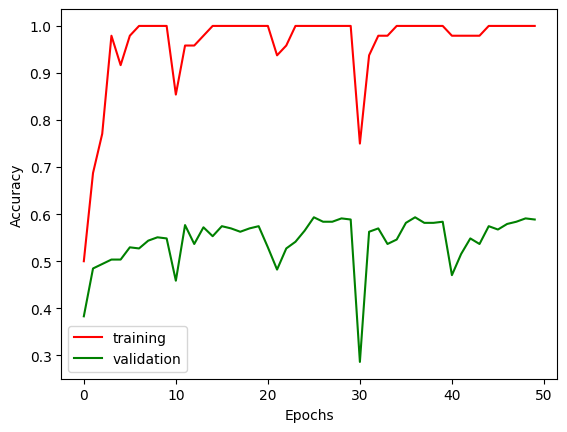

In [17]:
make_figure(training_acc_CNN, validation_acc_CNN, name = "CNN")

In [18]:
# Testing Accuracy On Subject 1
test_ind = np.where(person_test == 1)[0]
X_test_subject_1 = X_test[test_ind]
y_test_subject_1 = y_test[test_ind]
test_model(resnet, model_choice="CNN", X_test=X_test_subject_1, y_test=y_test_subject_1)

Test accuracy for  RESNET is:  0.38
